# Выделение фации по паттерну
Используя dtw алгорим
 
https://habr.com/ru/post/334220/

идеально было бы найти и реализовать:

https://stackoverflow.com/questions/36549932/pattern-detection-in-time-series-data
https://www.cs.cmu.edu/~christos/PUBLICATIONS/ICDE07-spring.pdf

https://stackoverflow.com/questions/11752727/pattern-recognition-in-time-series

savgol_filter(v, 3, 1) для сглаживания

stats.zscore для того чтобы сравнивать только форму кривой, а не абсалютные значения

In [3]:
import pandas as pd
from IPython.display import display
from scipy import stats
from scipy.signal import savgol_filter
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# выгружаем данные
def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 2000]
    return feature


def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

for_ml = get_for_learn_clean_df(pd.read_csv('Correct_train_26.csv', sep=';'))

GR_FOR_DTW = 'GR'

In [5]:
display(for_ml.describe())
display(for_ml)
print(for_ml['wellName'].unique())

MD           AGR           ANK           ASP             BK  \
count  54105.000000  54105.000000  17966.000000  48435.000000   42081.000000   
mean    2469.522063    -59.264651    -32.599455    -74.680196      20.384135   
std      279.358082    770.303105    576.934861    862.407403    1211.259990   
min     2000.200000  -9999.000000  -9999.000000  -9999.000000   -9999.000000   
25%     2242.600000      0.209582      0.715249      0.034973       6.025100   
50%     2468.000000      0.401921      0.830367      0.132010       7.336100   
75%     2644.400000      0.644005      0.926317      0.387919       8.924600   
max     3270.800000      1.000000      1.000000      1.000000  116144.860000   

             Facies    Facies_LIT            GR           LIT          NKTB  \
count  54105.000000  54105.000000  54105.000000  49698.000000  54105.000000   
mean   -9083.993790  -9773.810868    -61.512303  -5157.205260   -753.978387   
std     2883.750067   1483.892001    847.901761   4997.899469   2647.613038   
min    -9999.000000  -9999.000000  -9999.000000  -9999.000000  -9999.000000   
25%    -9999.000000  -9999.000000      7.530000  -9999.000000      3.470000   
50%    -9999.000000  -9999.000000      9.770000  -9999.000000      3.900640   
75%    -9999.000000  -9999.000000     12.140000      1.000000      4.510000   
max       12.000000     12.000000    108.920000      6.000000     24.130000   

                 SP  
count  52842.000000  
mean     -23.871623  
std     1140.683476  
min    -9999.000000  
25%       75.900002  
50%      107.078250  
75%      135.510750  
max      218.061000

wellName      MD       AGR  ANK       ASP     BK  Facies  Facies_LIT  \
1401   spk1036  2000.2  0.650117  NaN  0.412179  6.300   -9999       -9999   
1402   spk1036  2000.4  0.534454  NaN  0.331220  5.900   -9999       -9999   
1403   spk1036  2000.6  0.545131  NaN  0.288386  5.400   -9999       -9999   
1404   spk1036  2000.8  0.598514  NaN  0.289824  7.600   -9999       -9999   
1405   spk1036  2001.0  0.675029  NaN  0.324467  6.500   -9999       -9999   
...        ...     ...       ...  ...       ...    ...     ...         ...   
76602  spk432R  2664.4  0.234586  1.0  0.000000  5.869   -9999       -9999   
76603  spk432R  2664.6  0.274610  1.0  0.000000  6.166   -9999       -9999   
76604  spk432R  2664.8  0.203586  1.0  0.000000  7.917   -9999       -9999   
76605  spk432R  2665.0  0.107808  1.0  0.000000  8.308   -9999       -9999   
76606  spk432R  2665.2  0.110353  1.0  0.000000  8.206   -9999       -9999   

           GR  LAYER  LIT        NKTB       SP  
1401    5.990  -9999  1.0 -9999.00000   57.400  
1402    6.640  -9999  1.0 -9999.00000   64.000  
1403    6.580  -9999  1.0 -9999.00000   67.500  
1404    6.280  -9999  1.0 -9999.00000   67.400  
1405    5.850  -9999  1.0 -9999.00000   64.600  
...       ...    ...  ...         ...      ...  
76602  14.252     U1  1.0     3.15011  198.362  
76603  13.906     U1  1.0     3.06579  198.828  
76604  14.520     U1  1.0     2.98865  198.490  
76605  15.348     U1  1.0     2.54313  198.255  
76606  15.326     U1  1.0     2.50426  198.267  

[54105 rows x 13 columns]

['spk1036' 'spk1150' 'spk1518' 'spk1519' 'spk1521' 'spk1527' 'spk1743'
 'spk1746' 'spk1747' 'spk1749PL' 'spk1750PL' 'spk1768' 'spk1769'
 'spk1779PL' 'spk1799PL' 'spk400' 'spk403' 'spk405R' 'spk409R' 'spk420R'
 'spk424R' 'spk426R' 'spk427R' 'spk428R' 'spk429L' 'spk432R']


# Задаём паттерн, который будем искать в кривых по dtw

In [6]:
pattern_well_name = 'spk1749PL'
pattern_well_depth_start = 2623.3  # метров
pattern_well_depth_delta = 11  # метров


def get_filter_savgol_default(timeserials):
    return savgol_filter(timeserials, 3, 1)


def get_bets_intervals_starts(wells, feature_name):
    def get_part_feature(well, md_start, depth_delta):
        part = well[well['MD'] >= md_start]
        part = part[part['MD'] < md_start + depth_delta]
        return part[feature_name]

    pattern = pd.DataFrame()

    for well in wells:
        copy = well.copy()
        if pattern_well_name in well['wellName'].unique():
            v = get_part_feature(copy, pattern_well_depth_start, pattern_well_depth_delta)
            pattern[pattern_well_name] = get_filter_savgol_default(v)
            pattern[pattern_well_name] = stats.zscore(pattern[pattern_well_name])
            continue

    return pattern


parts_7_facies_df = get_bets_intervals_starts(get_well_dfs(for_ml), GR_FOR_DTW)

spk1749PL
0    5.159358
1    2.999383
2    1.365398
3    0.783598
4    0.368971
5    0.289731
6    0.527039
7    0.701055
8    0.676002
9    0.520387
10   0.324256
11   0.188024
12   0.129476
13   0.185777
14   0.343522
15   0.512721
16   0.566835
17   0.429252
18   0.133793
19  -0.103426
20  -0.105688
21   0.081941
22   0.220507
23   0.141635
24  -0.051985
25  -0.217543
26  -0.287369
27  -0.253241
28  -0.128538
29   0.012364
30   0.111369
31   0.140988
32   0.038385
33  -0.206088
34  -0.450782
35  -0.463793
36  -0.295842
37  -0.190787
38  -0.321629
39  -0.482399
40  -0.530051
41  -0.557013
42  -0.683860
43  -0.848243
44  -0.950303
45  -0.954238
46  -0.869463
47  -0.792103
48  -0.745787
49  -0.749986
50  -0.826201
51  -0.992903
52  -1.201708
53  -1.323196
54  -1.367603

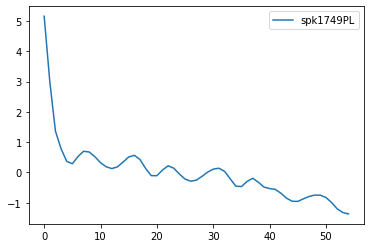

In [7]:
display(parts_7_facies_df)
display(parts_7_facies_df.plot())


In [8]:
def get_dtw_intervals(wells_all, best_signal, feature_name):
    def rolling_dtw(df):
        ideal = best_signal.values

        def get_distance(grs):
            grs_filter = get_filter_savgol_default(grs)
            current = stats.zscore(grs_filter)
            return fastdtw(current, ideal)[0]

        return df[feature_name].rolling(len(best_signal)).apply(get_distance)

    wells = get_well_dfs(wells_all)
    for well in wells:
        print(well['wellName'].unique())
        correlations_part = rolling_dtw(well)
        well['correlations_part'] = correlations_part
    result_df = pd.concat(wells)
    return result_df['correlations_part']


def get_with_dtw(wells_all, signals_7_facies, feature_name):
    name_wells = signals_7_facies.columns
    result = wells_all.copy()
    for name_well in name_wells:
        result[name_well + '_dtw'] = get_dtw_intervals(wells_all,
                                                       signals_7_facies[name_well],
                                                       feature_name)
        result[name_well + '_dtw_sum'] = result[name_well + '_dtw'].rolling(10).sum()
        result[name_well + '_dtw'] = result[name_well + '_dtw'].clip(-80, 80)
        max_ = result[name_well + '_dtw'].max()
        min_ = result[name_well + '_dtw'].min()
        result[name_well + '_dtw_probability'] = 1 - (result[name_well + '_dtw'] - min_) / (max_ - min_)
    return result


predicts_df = get_with_dtw(for_ml, parts_7_facies_df, GR_FOR_DTW)

['spk1036']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


['spk1150']
['spk1518']
['spk1519']
['spk1521']
['spk1527']
['spk1743']
['spk1746']
['spk1747']
['spk1749PL']
['spk1750PL']
['spk1768']
['spk1769']
['spk1779PL']
['spk1799PL']
['spk400']
['spk403']
['spk405R']
['spk409R']
['spk420R']
['spk424R']
['spk426R']
['spk427R']
['spk428R']
['spk429L']
['spk432R']


In [9]:
predicts_df.describe()

MD           AGR           ANK           ASP             BK  \
count  54105.000000  54105.000000  17966.000000  48435.000000   42081.000000   
mean    2469.522063    -59.264651    -32.599455    -74.680196      20.384135   
std      279.358082    770.303105    576.934861    862.407403    1211.259990   
min     2000.200000  -9999.000000  -9999.000000  -9999.000000   -9999.000000   
25%     2242.600000      0.209582      0.715249      0.034973       6.025100   
50%     2468.000000      0.401921      0.830367      0.132010       7.336100   
75%     2644.400000      0.644005      0.926317      0.387919       8.924600   
max     3270.800000      1.000000      1.000000      1.000000  116144.860000   

             Facies    Facies_LIT            GR           LIT          NKTB  \
count  54105.000000  54105.000000  54105.000000  49698.000000  54105.000000   
mean   -9083.993790  -9773.810868    -61.512303  -5157.205260   -753.978387   
std     2883.750067   1483.892001    847.901761   4997.899469   2647.613038   
min    -9999.000000  -9999.000000  -9999.000000  -9999.000000  -9999.000000   
25%    -9999.000000  -9999.000000      7.530000  -9999.000000      3.470000   
50%    -9999.000000  -9999.000000      9.770000  -9999.000000      3.900640   
75%    -9999.000000  -9999.000000     12.140000      1.000000      4.510000   
max       12.000000     12.000000    108.920000      6.000000     24.130000   

                 SP  spk1749PL_dtw  spk1749PL_dtw_sum  \
count  52842.000000   52701.000000       52467.000000   
mean     -23.871623      48.760103         487.920870   
std     1140.683476      14.531018         139.347730   
min    -9999.000000       0.000000         117.054527   
25%       75.900002      38.735082         394.040132   
50%      107.078250      48.929982         490.824547   
75%      135.510750      58.633355         580.919813   
max      218.061000      80.000000         843.218867   

       spk1749PL_dtw_probability  
count               52701.000000  
mean                    0.390499  
std                     0.181638  
min                     0.000000  
25%                     0.267083  
50%                     0.388375  
75%                     0.515811  
max                     1.000000

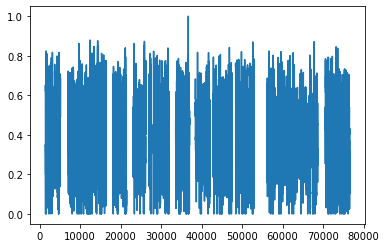

In [10]:
predicts_df[pattern_well_name +'_dtw_probability'].plot()

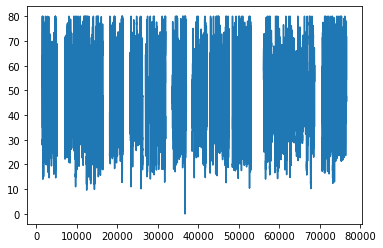

In [11]:
predicts_df[pattern_well_name +'_dtw'].plot()

In [12]:
predicts_df[predicts_df[pattern_well_name + '_dtw'] < 14]

wellName      MD       AGR       ANK       ASP     BK  Facies  \
9698   spk1150  2539.4  0.000000       NaN  0.039460   1.60   -9999   
9705   spk1150  2540.8  0.514017       NaN  0.079444   6.30   -9999   
9706   spk1150  2541.0  0.296836       NaN  0.031801   4.50   -9999   
9707   spk1150  2541.2  0.226126       NaN  0.035371   4.60   -9999   
9708   spk1150  2541.4  0.322090       NaN  0.057679   3.80   -9999   
...        ...     ...       ...       ...       ...    ...     ...   
73215   spk400  2542.2  0.824561  0.759335  0.303147  20.50       7   
73216   spk400  2542.4  0.778947  0.741802  0.239410  18.80       7   
73217   spk400  2542.6  0.717544  0.703813  0.173018  15.68       7   
73623   spk403  2569.6  0.775635  0.729853  0.274603   6.95       0   
73624   spk403  2569.8  0.779010  0.798937  0.307122   6.85       0   

       Facies_LIT    GR  LAYER  LIT     NKTB        SP  spk1749PL_dtw  \
9698        -9999  8.31  UV1_0  1.0  3.82080  105.6000      13.982321   
9705        -9999  6.12  UV1_0  1.0  3.82080  102.3000      13.896649   
9706        -9999  6.98  UV1_0  1.0  3.76980  106.1000      11.801596   
9707        -9999  7.26  UV1_1  1.0  3.83100  105.8000      10.988303   
9708        -9999  6.88  UV1_1  1.0  3.88200  104.0000      11.424968   
...           ...   ...    ...  ...      ...       ...            ...   
73215           7  5.70     U1  4.0  3.89000   99.7000      13.611660   
73216       -9999  5.96     U1  2.0  3.95000  104.5000      13.141102   
73217       -9999  6.31     U1  2.0  4.08000  109.5000      12.353029   
73623           0  6.50     U1  4.0  4.34963   59.1757      12.960556   
73624           0  6.48     U1  4.0  4.01641   56.9891      13.562961   

       spk1749PL_dtw_sum  spk1749PL_dtw_probability  
9698          153.725296                   0.825221  
9705          149.889383                   0.826292  
9706          146.616392                   0.852480  
9707          142.816752                   0.862646  
9708          140.259399                   0.857188  
...                  ...                        ...  
73215         161.287442                   0.829854  
73216         160.530365                   0.835736  
73217         158.887030                   0.845587  
73623         199.442483                   0.837993  
73624         188.071066                   0.830463  

[123 rows x 16 columns]

In [13]:
def predict_facies_stationary_dtw(row):
    f_0 = row[pattern_well_name + '_dtw']
    if f_0 < 20:# значение взято наугад
        return 7
    return 3

def predict_facies_dtw(x, border):
    facies_target = 7
    facies_undefined = 3
    return facies_target if x < border else facies_undefined

def get_predict_for_border(predicts_df, border, feature):
    return predicts_df[feature].apply(lambda x: predict_facies_dtw(x, border))

global_name_predict_model_dtw = 'predict_' + pattern_well_name +'_dtw'
predicts_df[global_name_predict_model_dtw] = predicts_df.apply(predict_facies_stationary_dtw, axis=1)
predicts_df[global_name_predict_model_dtw + '_border_14'] = get_predict_for_border(predicts_df, 14, pattern_well_name + '_dtw')

In [14]:
display(predicts_df.describe())
display(predicts_df)

MD           AGR           ANK           ASP             BK  \
count  54105.000000  54105.000000  17966.000000  48435.000000   42081.000000   
mean    2469.522063    -59.264651    -32.599455    -74.680196      20.384135   
std      279.358082    770.303105    576.934861    862.407403    1211.259990   
min     2000.200000  -9999.000000  -9999.000000  -9999.000000   -9999.000000   
25%     2242.600000      0.209582      0.715249      0.034973       6.025100   
50%     2468.000000      0.401921      0.830367      0.132010       7.336100   
75%     2644.400000      0.644005      0.926317      0.387919       8.924600   
max     3270.800000      1.000000      1.000000      1.000000  116144.860000   

             Facies    Facies_LIT            GR           LIT          NKTB  \
count  54105.000000  54105.000000  54105.000000  49698.000000  54105.000000   
mean   -9083.993790  -9773.810868    -61.512303  -5157.205260   -753.978387   
std     2883.750067   1483.892001    847.901761   4997.899469   2647.613038   
min    -9999.000000  -9999.000000  -9999.000000  -9999.000000  -9999.000000   
25%    -9999.000000  -9999.000000      7.530000  -9999.000000      3.470000   
50%    -9999.000000  -9999.000000      9.770000  -9999.000000      3.900640   
75%    -9999.000000  -9999.000000     12.140000      1.000000      4.510000   
max       12.000000     12.000000    108.920000      6.000000     24.130000   

                 SP  spk1749PL_dtw  spk1749PL_dtw_sum  \
count  52842.000000   52701.000000       52467.000000   
mean     -23.871623      48.760103         487.920870   
std     1140.683476      14.531018         139.347730   
min    -9999.000000       0.000000         117.054527   
25%       75.900002      38.735082         394.040132   
50%      107.078250      48.929982         490.824547   
75%      135.510750      58.633355         580.919813   
max      218.061000      80.000000         843.218867   

       spk1749PL_dtw_probability  predict_spk1749PL_dtw  \
count               52701.000000           54105.000000   
mean                    0.390499               3.084650   
std                     0.181638               0.575709   
min                     0.000000               3.000000   
25%                     0.267083               3.000000   
50%                     0.388375               3.000000   
75%                     0.515811               3.000000   
max                     1.000000               7.000000   

       predict_spk1749PL_dtw_border_14  
count                     54105.000000  
mean                          3.009093  
std                           0.190504  
min                           3.000000  
25%                           3.000000  
50%                           3.000000  
75%                           3.000000  
max                           7.000000

wellName      MD       AGR  ANK       ASP     BK  Facies  Facies_LIT  \
1401   spk1036  2000.2  0.650117  NaN  0.412179  6.300   -9999       -9999   
1402   spk1036  2000.4  0.534454  NaN  0.331220  5.900   -9999       -9999   
1403   spk1036  2000.6  0.545131  NaN  0.288386  5.400   -9999       -9999   
1404   spk1036  2000.8  0.598514  NaN  0.289824  7.600   -9999       -9999   
1405   spk1036  2001.0  0.675029  NaN  0.324467  6.500   -9999       -9999   
...        ...     ...       ...  ...       ...    ...     ...         ...   
76602  spk432R  2664.4  0.234586  1.0  0.000000  5.869   -9999       -9999   
76603  spk432R  2664.6  0.274610  1.0  0.000000  6.166   -9999       -9999   
76604  spk432R  2664.8  0.203586  1.0  0.000000  7.917   -9999       -9999   
76605  spk432R  2665.0  0.107808  1.0  0.000000  8.308   -9999       -9999   
76606  spk432R  2665.2  0.110353  1.0  0.000000  8.206   -9999       -9999   

           GR  LAYER  LIT        NKTB       SP  spk1749PL_dtw  \
1401    5.990  -9999  1.0 -9999.00000   57.400            NaN   
1402    6.640  -9999  1.0 -9999.00000   64.000            NaN   
1403    6.580  -9999  1.0 -9999.00000   67.500            NaN   
1404    6.280  -9999  1.0 -9999.00000   67.400            NaN   
1405    5.850  -9999  1.0 -9999.00000   64.600            NaN   
...       ...    ...  ...         ...      ...            ...   
76602  14.252     U1  1.0     3.15011  198.362      47.321436   
76603  13.906     U1  1.0     3.06579  198.828      46.499072   
76604  14.520     U1  1.0     2.98865  198.490      45.435198   
76605  15.348     U1  1.0     2.54313  198.255      46.954407   
76606  15.326     U1  1.0     2.50426  198.267      47.502129   

       spk1749PL_dtw_sum  spk1749PL_dtw_probability  predict_spk1749PL_dtw  \
1401                 NaN                        NaN                      3   
1402                 NaN                        NaN                      3   
1403                 NaN                        NaN                      3   
1404                 NaN                        NaN                      3   
1405                 NaN                        NaN                      3   
...                  ...                        ...                    ...   
76602         549.072407                   0.408482                      3   
76603         538.330614                   0.418762                      3   
76604         524.909466                   0.432060                      3   
76605         511.812048                   0.413070                      3   
76606         501.259121                   0.406223                      3   

       predict_spk1749PL_dtw_border_14  
1401                                 3  
1402                                 3  
1403                                 3  
1404                                 3  
1405                                 3  
...                                ...  
76602                                3  
76603                                3  
76604                                3  
76605                                3  
76606                                3  

[54105 rows x 18 columns]

In [15]:
def get_wells_with_7_facies(wells_all):
    wells_7_namens = wells_all[wells_all[global_name_predict_model_dtw + '_border_14'] == 7]['wellName'].unique()
    print(wells_7_namens)
    wells = []
    for name in wells_7_namens:
        well = wells_all[wells_all['wellName'] == name]
        wells.append(well)
    return pd.concat(wells)

predicts_7_fecies_df = get_wells_with_7_facies(predicts_df)
predicts_7_fecies_df.to_csv('train_7_predict_for_' + pattern_well_name + '_dtw_.csv', sep=';')

['spk1150' 'spk1518' 'spk1743' 'spk1746' 'spk1747' 'spk1749PL' 'spk1768'
 'spk1779PL' 'spk1799PL' 'spk400' 'spk403']


# Предсказываем интервалы в экспертном наборе данных

In [16]:
def get_clean_df(statistic_df):
    feature = statistic_df.copy()
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 2000]
    del feature['datasetName']
    return feature

dataset_for_predict_preproc = get_clean_df(pd.read_csv('Correct_test_26.csv', sep=';'))

In [17]:
predicts_prod_df = get_with_dtw(dataset_for_predict_preproc, parts_7_facies_df, GR_FOR_DTW)

['spk1205L']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


['spk146R']
['spk1508']
['spk1528']
['spk1650PL']
['spk1656PL']
['spk1700']
['spk1701']
['spk1703']
['spk1707']
['spk1710']
['spk1718']
['spk1725']
['spk1740']
['spk1741']
['spk1742']
['spk1745L']
['spk1753']
['spk1755']
['spk1764']
['spk1765']
['spk1779']
['spk1791']
['spk1792']
['spk1793']
['spk1794']
['spk1796']
['spk1805']
['spk214P']
['spk236']
['spk401']
['spk404']
['spk408']
['spk421R']
['spk422R']
['spk437']
['spk467']
['spk564P']
['spk632']
['spk804']
['spk805']
['spk808']
['spk833R']
['spk870PL']
['spk872PL']
['spk902']
['spk904']
['spk908']
['spk914']
['spk924L']
['spk941']
['spk963L']


In [18]:
predicts_prod_df[predicts_prod_df[pattern_well_name +'_dtw'] < 14]

wellName      MD       AGR       ANK       ASP       BK       GR  \
26882   spk146R  2595.4  0.060437  0.661331  0.060437  5.13782  3.61099   
26883   spk146R  2595.6  0.098161  0.664400  0.098161  4.98853  3.54334   
26884   spk146R  2595.8  0.102085  0.618416  0.102085  6.73248  3.49260   
26885   spk146R  2596.0  0.088545  0.602073  0.088545  9.04156  3.52220   
26886   spk146R  2596.2  0.071790  0.575508  0.071790  5.39664  3.40381   
...         ...     ...       ...       ...       ...      ...      ...   
534725  spk963L  2756.6  0.256960  0.868996  0.023184  9.00000  7.58000   
534726  spk963L  2756.8  0.193195  0.897386  0.017880  9.30000  7.90000   
534727  spk963L  2757.0  0.302791  0.823572  0.024510  8.60000  7.35000   
534728  spk963L  2757.2  0.617629  0.613484  0.025836  8.70000  5.77000   
534729  spk963L  2757.4  0.808923  0.585094  0.032466  9.90000  4.81000   

        LAYER  LIT     NKTB        SP  spk1749PL_dtw  spk1749PL_dtw_sum  \
26882      U1  1.0  4.37020  134.0317      13.829939         151.954192   
26883      U1  1.0  4.35786  129.6807      13.222872         149.321289   
26884      U1  1.0  4.54283  129.2267      13.108338         147.045329   
26885      U1  1.0  4.60857  130.7787      13.231269         145.127849   
26886      U1  1.0  4.71543  132.7037      13.733669         143.489383   
...       ...  ...      ...       ...            ...                ...   
534725  UV1_1  1.0  2.10000   97.1000      13.587028         148.332256   
534726  UV1_1  1.0  2.05000   97.5000      12.893198         147.857506   
534727  UV1_1  5.0  2.18000   97.0000      13.065328         146.284766   
534728  UV1_1  5.0  2.55000   96.9000      12.851393         143.548459   
534729  UV1_1  5.0  2.60000   96.4000      13.249063         141.666627   

        spk1749PL_dtw_probability  
26882                    0.916577  
26883                    0.924986  
26884                    0.926572  
26885                    0.924869  
26886                    0.917910  
...                           ...  
534725                   0.919941  
534726                   0.929552  
534727                   0.927168  
534728                   0.930131  
534729                   0.924623  

[330 rows x 14 columns]

In [19]:
predicts_prod_df[global_name_predict_model_dtw] = predicts_prod_df.apply(predict_facies_stationary_dtw, axis=1)
predicts_prod_df[global_name_predict_model_dtw + '_border_14'] = get_predict_for_border(predicts_prod_df, 14, pattern_well_name + '_dtw')

In [20]:
display(predicts_prod_df.describe())
display(predicts_prod_df)

MD            AGR            ANK            ASP  \
count  195867.000000  195867.000000  195867.000000  195867.000000   
mean     2390.036288    -828.650600    -664.375657     -74.172092   
std       240.027688    2757.272042    2491.840648     859.497660   
min      2000.200000   -9999.000000   -9999.000000   -9999.000000   
25%      2189.200000       0.111532       0.682526       0.028488   
50%      2378.200000       0.317959       0.832534       0.123000   
75%      2567.500012       0.562216       0.947687       0.404682   
max      3180.800000       1.000000       1.000000       1.000000   

                 BK             GR            LIT           NKTB  \
count  1.864690e+05  195867.000000  195867.000000  195867.000000   
mean  -1.542010e+02    -766.273557   -6092.945019    -661.566401   
std    1.489385e+04    2676.879684    4879.225498    2492.590929   
min   -9.999000e+03   -9999.000000   -9999.000000   -9999.000000   
25%    5.778600e+00       6.500000   -9999.000000       2.775390   
50%    7.200000e+00       8.402000   -9999.000000       3.700000   
75%    9.270000e+00      10.752700       1.000000       4.320000   
max    6.402033e+06     164.851000       6.000000      23.520000   

                  SP  spk1749PL_dtw  spk1749PL_dtw_sum  \
count  195867.000000  193059.000000      192591.000000   
mean     -129.045015      48.171539         482.121316   
std      1486.559301      14.236667         136.726266   
min     -9999.000000       7.807384         115.807321   
25%        68.378475      38.625919         391.606441   
50%        95.096800      47.671667         476.716669   
75%       119.357450      57.610204         572.709664   
max       237.231000      80.000000         858.510656   

       spk1749PL_dtw_probability  predict_spk1749PL_dtw  \
count              193059.000000          195867.000000   
mean                    0.440882               3.085834   
std                     0.197204               0.579629   
min                     0.000000               3.000000   
25%                     0.310140               3.000000   
50%                     0.447807               3.000000   
75%                     0.573107               3.000000   
max                     1.000000               7.000000   

       predict_spk1749PL_dtw_border_14  
count                    195867.000000  
mean                          3.006739  
std                           0.164048  
min                           3.000000  
25%                           3.000000  
50%                           3.000000  
75%                           3.000000  
max                           7.000000

wellName      MD       AGR       ANK       ASP    BK     GR  LAYER  \
9986    spk1205L  2000.2  0.594596  1.000000  0.437392  6.17   6.38  -9999   
9987    spk1205L  2000.4  0.442517  1.000000  0.271869  4.43   7.32  -9999   
9988    spk1205L  2000.6  0.393982  1.000000  0.177362  4.01   7.62  -9999   
9989    spk1205L  2000.8  0.368096  1.000000  0.134934  3.73   7.78  -9999   
9990    spk1205L  2001.0  0.389128  1.000000  0.076775  4.01   7.65  -9999   
...          ...     ...       ...       ...       ...   ...    ...    ...   
534978   spk963L  2807.2  0.000000  0.982557  0.011250  7.30  10.13  UV1_3   
534979   spk963L  2807.4  0.000000  0.976879  0.025836  7.70  10.06  UV1_3   
534980   spk963L  2807.6  0.000000  0.942811  0.032466  7.50   9.60  UV1_3   
534981   spk963L  2807.8  0.115482  0.681621  0.036444  6.60   8.29  UV1_3   
534982   spk963L  2808.0  0.115482  0.681621  0.036444  6.60   8.29  UV1_3   

           LIT  NKTB         SP  spk1749PL_dtw  spk1749PL_dtw_sum  \
9986   -9999.0  2.02   79.69931            NaN                NaN   
9987   -9999.0  2.02   90.53747            NaN                NaN   
9988   -9999.0  2.00   96.72562            NaN                NaN   
9989   -9999.0  1.97   99.50378            NaN                NaN   
9990   -9999.0  2.03  103.31190            NaN                NaN   
...        ...   ...        ...            ...                ...   
534978 -9999.0  1.90   98.00000      68.461523         686.211988   
534979 -9999.0  1.91   96.90000      65.146164         681.593655   
534980 -9999.0  1.97   96.40000      70.804382         682.852627   
534981 -9999.0  2.43   96.10000      68.360062         682.933483   
534982 -9999.0  2.43   96.10000      64.751197         679.850524   

        spk1749PL_dtw_probability  predict_spk1749PL_dtw  \
9986                          NaN                      3   
9987                          NaN                      3   
9988                          NaN                      3   
9989                          NaN                      3   
9990                          NaN                      3   
...                           ...                    ...   
534978                   0.159829                      3   
534979                   0.205753                      3   
534980                   0.127376                      3   
534981                   0.161234                      3   
534982                   0.211224                      3   

        predict_spk1749PL_dtw_border_14  
9986                                  3  
9987                                  3  
9988                                  3  
9989                                  3  
9990                                  3  
...                                 ...  
534978                                3  
534979                                3  
534980                                3  
534981                                3  
534982                                3  

[195867 rows x 16 columns]

In [ ]:
predicts_7_fecies_prod_df = get_wells_with_7_facies(predicts_prod_df)
predicts_7_fecies_prod_df.to_csv('test_7_predict_for_'  + pattern_well_name +  '_dtw.csv', sep=';')